In [ ]:
!pip install adata
!pip install scanpy
!pip install squidpy

In [ ]:
!pip install SpaGCN

In [1]:
import platform


In [ ]:
!git clone https://github.com/jianhuupenn/SpaGCN

fatal: destination path 'SpaGCN' already exists and is not an empty directory.


In [ ]:
!cd SpaGCN/SpaGCN_package/
!python3 setup.py install --user

python3: can't open file '/content/setup.py': [Errno 2] No such file or directory


In [82]:
import numpy as np
import pandas as pd

import anndata as ad
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc


# Load the Visium data
adata = sc.read_visium(
    '/content/15670/',
    count_file='filtered_feature_bc_matrix.h5',
    load_images=True
)
adata.var_names_make_unique()  # Make variable names unique


In [86]:
adata.X

<3498x33538 sparse matrix of type '<class 'numpy.float32'>'
	with 5859140 stored elements in Compressed Sparse Row format>

In [89]:
import numpy as np
import scanpy as sc
import scipy.sparse as sp

# Assuming you have already loaded your adata object
# Read and process your data here if not yet done
# adata = sc.read_10x_h5("path_to_your_data.h5")

# Calculate the total counts per cell
if sp.issparse(adata.X):
    # Ensure the data is treated as a sparse matrix for summing
    adata.obs['total_counts'] = np.array(adata.X.sum(axis=1)).flatten()
else:
    adata.obs['total_counts'] = adata.X.sum(axis=1)

# Now let's redo the function for calculating percentage counts for top genes
def pct_counts_in_top_genes(adata, n_top_genes):
    sum_axis_0 = np.array(adata.X.sum(axis=0)).flatten() if sp.issparse(adata.X) else adata.X.sum(axis=0)

    top_genes_indices = np.argsort(sum_axis_0)[::-1][:n_top_genes]
    top_gene_matrix = adata[:, top_genes_indices].X
    top_gene_counts = np.array(top_gene_matrix.sum(axis=1)).flatten() if sp.issparse(top_gene_matrix) else top_gene_matrix.sum(axis=1)

    total_counts = adata.obs['total_counts']


    pct_counts = np.zeros_like(total_counts)
    nonzero = total_counts > 0
    pct_counts[nonzero] = (top_gene_counts[nonzero] / total_counts[nonzero]) * 100

    return pct_counts

# Apply the function and update AnnData observation dataframe
adata.obs['pct_counts_in_top_50_genes'] = pct_counts_in_top_genes(adata, 50)
adata.obs['pct_counts_in_top_100_genes'] = pct_counts_in_top_genes(adata, 100)
adata.obs['pct_counts_in_top_200_genes'] = pct_counts_in_top_genes(adata, 200)
adata.obs['pct_counts_in_top_500_genes'] = pct_counts_in_top_genes(adata, 500)


In [88]:
adata.obs

,in_tissue,array_row,array_col,total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAACAAGTATCTCCCA-1,1,50,102,5131.0,33.658157,38.822842,45.819527,56.831024
AAACACCAATAACTGC-1,1,59,19,6098.0,28.566742,34.322731,41.325024,53.378159
AAACAGAGCGACTCCT-1,1,14,94,3384.0,33.451538,38.297874,44.917259,56.205673
AAACAGCTTTCAGAAG-1,1,43,9,3849.0,27.020004,33.099506,41.491299,53.910107
AAACAGGGTCTATATT-1,1,47,13,2965.0,29.747047,35.210793,43.575043,54.873528
...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77,1972.0,33.164303,39.503044,48.580124,60.496956
TTGTTTCACATCCAGG-1,1,58,42,5058.0,25.326216,31.059706,37.544483,48.991695
TTGTTTCATTAGTCTA-1,1,60,30,5618.0,23.264507,29.120684,36.133854,48.967602
TTGTTTCCATACAACT-1,1,45,27,2967.0,32.457027,37.681160,44.084934,55.409504


In [9]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.var['mt'] = mito_genes  # Create a mitochondrial gene indicator in var
adata.obs['total_counts_mt'] = adata[:, mito_genes].X.sum(axis=1).A1
adata.obs['log1p_total_counts_mt'] = sc.pp.log1p(adata.obs['total_counts_mt'], copy=True)
adata.obs['pct_counts_mt'] = (adata.obs['total_counts_mt'] / adata.obs['total_counts']) * 100


In [10]:
adata

AnnData object with n_obs × n_vars = 3498 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'total_counts', 'log1p_total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'mt'
    uns: 'spatial'
    obsm: 'spatial'

In [11]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)


In [12]:
#adjust res to get clustering ; higher # = more clusters
sc.tl.leiden(adata, key_added="clusters", flavor="igraph", directed=False, n_iterations=2, resolution=0.4)


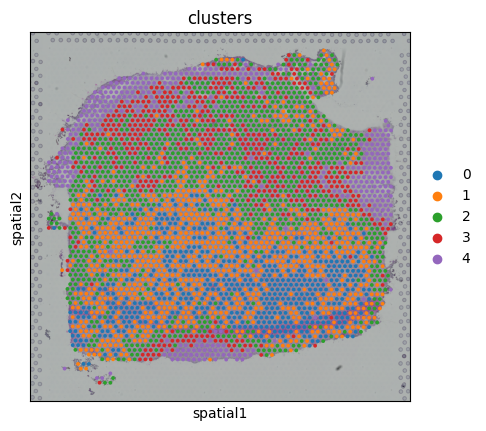

In [13]:

sc.pl.spatial(adata, img_key="hires", color="clusters", size=1)

In [58]:
#first iteration of genetic mapping

In [59]:
import scanpy as sc

# Filter cells and genes based on thresholds
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Normalize (total-count normalize) the gene expressions
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)


In [60]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]


In [61]:
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata)
sc.tl.umap(adata)


In [62]:
sc.tl.leiden(adata, resolution=1.1)


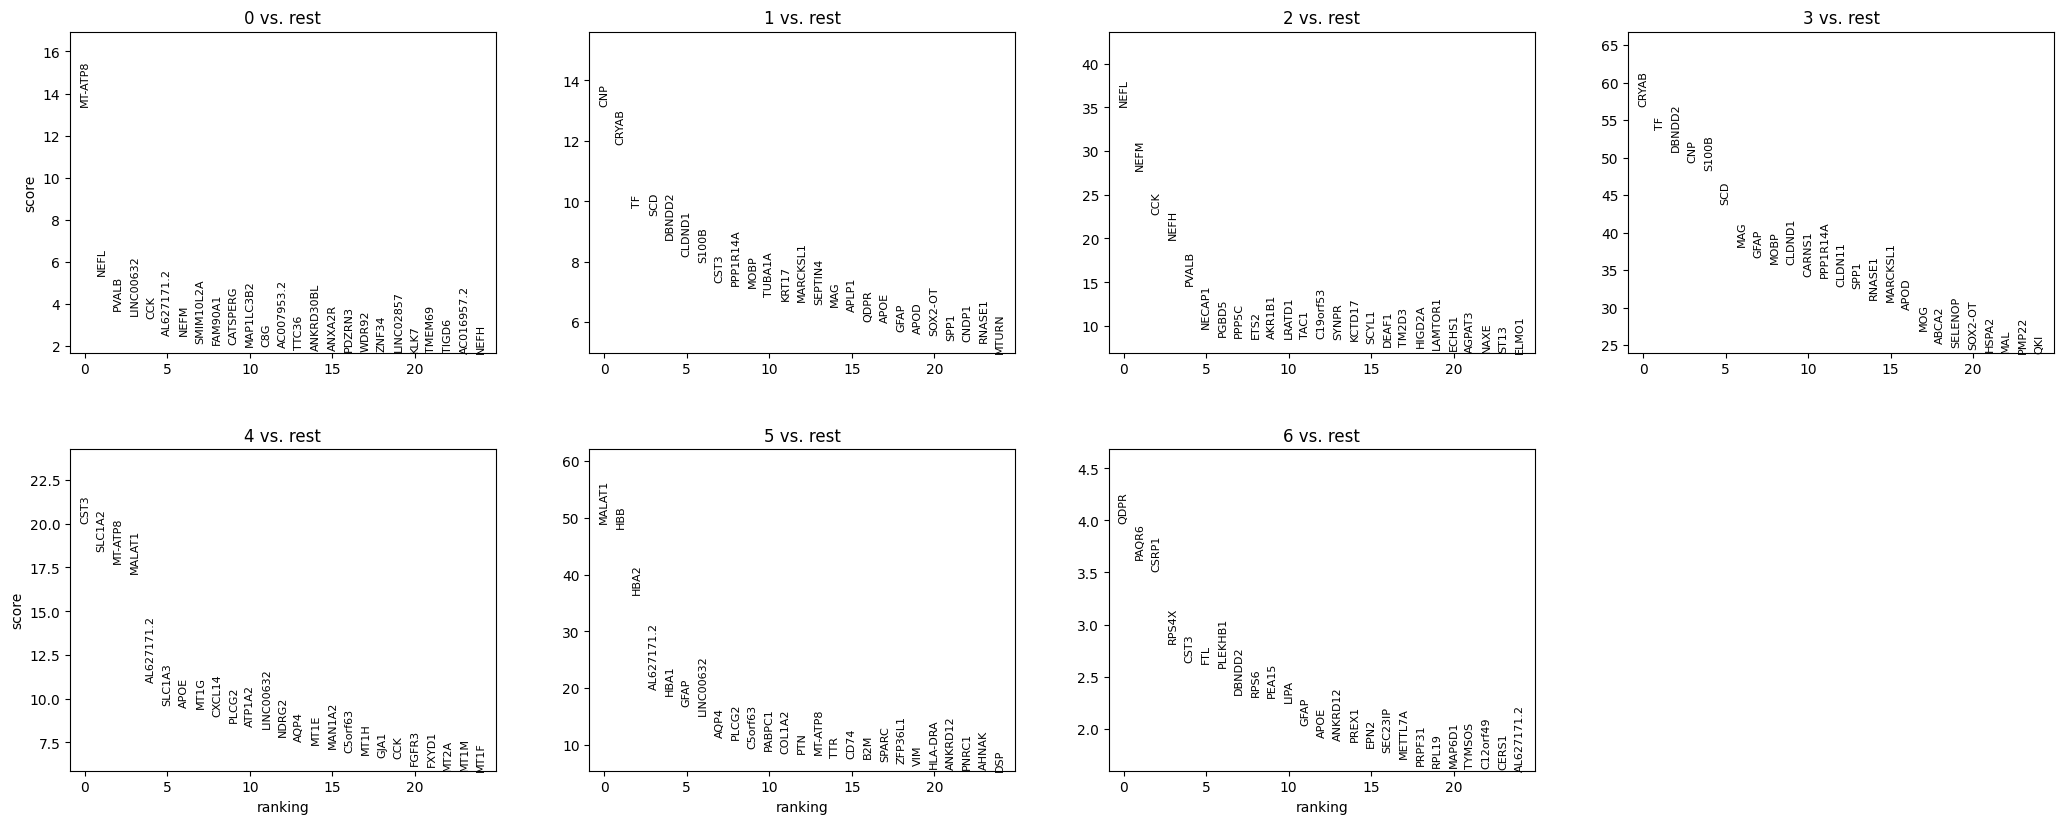

In [63]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


In [ ]:
# Example to rename based on known markers
cluster_annotations = {
    '0': 'MTATP8',
    '1': 'CNP',
    '2': 'NEFL',
    '3': 'CRYAB',
    '4': 'CST3',
    '5': 'MALAT1',
    '6': 'QDPR'
}
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_annotations)


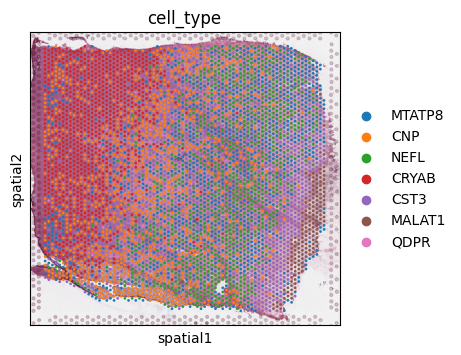

In [ ]:
#sc.pl.umap(adata, color='cell_type')
sc.pl.spatial(adata, img_key='hires', color='cell_type')


In [70]:
#2nd iteration  using SPACGCN

In [29]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import SpaGCN as spg
#In order to read in image data, we need to install some package. Here we recommend package "opencv"
#inatll opencv in python
#!pip3 install opencv-python
import cv2

In [74]:
from scanpy import read_10x_h5
adata = read_10x_h5("/content/Br2720_post/filtered_feature_bc_matrix.h5")
spatial=pd.read_csv("/content/Br2720_post/spatial/tissue_positions_list.csv",sep=",",header=None,na_filter=False,index_col=0)
adata.obs["in_tissue"]=spatial[1]
adata.obs["array_row"]=spatial[2]
adata.obs["array_col"]=spatial[3]
adata.obs["imagerow"]=spatial[4]
adata.obs["imagecol"]=spatial[5]

adata=adata[adata.obs["in_tissue"]==1]
adata.var_names=[i.upper() for i in list(adata.var_names)]
adata.var["genename"]=adata.var.index.astype("str")
adata.write_h5ad("/content/Br2720_post/data.h5ad")

adata = sc.read("/content/Br2720_post/data.h5ad")
img=cv2.imread("/content/Br2720_post/spatial/tissue_hires_image.png")



In [75]:
adata.obs

,in_tissue,array_row,array_col,imagerow,imagecol
AAACAAGTATCTCCCA-1,1,50,102,8571,10168
AAACACCAATAACTGC-1,1,59,19,9635,4453
AAACAGAGCGACTCCT-1,1,14,94,4258,9628
AAACAGCTTTCAGAAG-1,1,43,9,7717,3769
AAACAGGGTCTATATT-1,1,47,13,8197,4043
...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77,6291,8453
TTGTTTCACATCCAGG-1,1,58,42,9519,6036
TTGTTTCATTAGTCTA-1,1,60,30,9757,5210
TTGTTTCCATACAACT-1,1,45,27,7960,5008


In [48]:
#Set coordinates
x_array=adata.obs["array_row"].tolist()
y_array=adata.obs["array_col"].tolist()
x_pixel=adata.obs["imagerow"].tolist()
y_pixel=adata.obs["imagecol"].tolist()

#Test coordinates on the image
img_new=img.copy()
for i in range(len(x_pixel)):
    x=x_pixel[i]
    y=y_pixel[i]
    img_new[int(x-20):int(x+20), int(y-20):int(y+20),:]=0

cv2.imwrite('/content/Br2720_post/mapping.jpg', img_new)

True

In [49]:
s=1
b=49
#adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, x_pixel=x_pixel, y_pixel=y_pixel, image=img, beta=b, alpha=s, histology=True)
#If histlogy image is not available, SpaGCN can calculate the adjacent matrix using the fnction below
adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)
np.savetxt('/content/Br2720_post/adj.csv', adj, delimiter=',')

Calculateing adj matrix using xy only...


In [50]:
adata=sc.read("/content/Br2720_post/data.h5ad")
adj=np.loadtxt('/content/Br2720_post/adj.csv', delimiter=',')
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [51]:
p=0.5
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 85.02745046275741]
Run 2: l [0.01, 500.005], p [0.0, 21.505654999081848]
Run 3: l [0.01, 250.0075], p [0.0, 4.756461748275793]
recommended l =  125.00874999999999


In [52]:
#For this toy data, we set the number of clusters=7 since this tissue has 7 layers
n_clusters=7
#Set seed
r_seed=t_seed=n_seed=100
#Search for suitable resolution
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  7
recommended res =  0.7


In [62]:
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')
#Do cluster refinement(optional)
#shape="hexagon" for Visium data, "square" for ST data.
adj_2d=spg.calculate_adj_matrix(x=x_array,y=y_array, histology=False)
refined_pred=spg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred"].tolist(), dis=adj_2d, shape="hexagon")
adata.obs["layer_guess_reordered_short"]=refined_pred
adata.obs["layer_guess_reordered_short"]=adata.obs["layer_guess_reordered_short"].astype('category')
#Save results
adata.write_h5ad("/content/Br2720_post/results.h5ad")

Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Epoch  20
Epoch  30
delta_label  0.0034158838599487617 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 34
Calculateing adj matrix using xy only...


In [63]:
adata=sc.read("/content/Br2720_post/results.h5ad")
#adata.obs should contain two columns for x_pixel and y_pixel
#Set colors used
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
#Plot spatial domains
domains="pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="imagecol",y="imagerow",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig("/content/Br2720_post/pred.png", dpi=600)
plt.close()

#Plot refined spatial domains
domains="refined_pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="imagecol",y="imagerow",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig("/content/Br2720_post/refined_pred.png", dpi=600)
plt.close()

In [76]:
#identifying svgs
#Read in raw data
raw=sc.read("/content/Br2720_post/data.h5ad")
raw.var_names_make_unique()
raw.obs["pred"]=adata.obs["pred"].astype('category')
raw.obs["array_row"]=raw.obs["array_row"]
raw.obs["array_col"]=raw.obs["array_col"]
raw.obs["imagerow"]=raw.obs["imagerow"]
raw.obs["imagecol"]=raw.obs["imagecol"]
#Convert sparse matrix to non-sparse
raw.X=(raw.X.A if issparse(raw.X) else raw.X)
#raw.raw=raw
sc.pp.log1p(raw)

KeyError: 'pred'

In [65]:
target=0
#Set filtering criterials
min_in_group_fraction=0.8
min_in_out_group_ratio=1
min_fold_change=1.5
#Search radius such that each spot in the target domain has approximately 10 neighbors on average
adj_2d=spg.calculate_adj_matrix(x=x_array, y=y_array, histology=False)
start, end= np.quantile(adj_2d[adj_2d!=0],q=0.001), np.quantile(adj_2d[adj_2d!=0],q=0.1)
r=spg.search_radius(target_cluster=target, cell_id=adata.obs.index.tolist(), x=x_array, y=y_array, pred=adata.obs["pred"].tolist(), start=start, end=end, num_min=10, num_max=14,  max_run=100)
#Detect neighboring domains
nbr_domians=spg.find_neighbor_clusters(target_cluster=target,
                                   cell_id=raw.obs.index.tolist(),
                                   x=raw.obs["array_row"].tolist(),
                                   y=raw.obs["array_col"].tolist(),
                                   pred=raw.obs["pred"].tolist(),
                                   radius=r,
                                   ratio=1/2)

nbr_domians=nbr_domians[0:3]
de_genes_info=spg.rank_genes_groups(input_adata=raw,
                                target_cluster=target,
                                nbr_list=nbr_domians,
                                label_col="pred",
                                adj_nbr=True,
                                log=True)
#Filter genes
de_genes_info=de_genes_info[(de_genes_info["pvals_adj"]<0.05)]
filtered_info=de_genes_info
filtered_info=filtered_info[(filtered_info["pvals_adj"]<0.05) &
                            (filtered_info["in_out_group_ratio"]>min_in_out_group_ratio) &
                            (filtered_info["in_group_fraction"]>min_in_group_fraction) &
                            (filtered_info["fold_change"]>min_fold_change)]
filtered_info=filtered_info.sort_values(by="in_group_fraction", ascending=False)
filtered_info["target_dmain"]=target
filtered_info["neighbors"]=str(nbr_domians)
print("SVGs for domain ", str(target),":", filtered_info["genes"].tolist())

Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Run 1: radius [2.0, 18.867961883544922], num_nbr [8.77511111111111, 431.632]
Calculateing adj matrix using xy only...
Run 2: radius [2.0, 10.433980941772461], num_nbr [8.77511111111111, 154.8]
Calculateing adj matrix using xy only...
Run 3: radius [2.0, 6.2169904708862305], num_nbr [8.77511111111111, 56.52088888888889]
Calculateing adj matrix using xy only...
Run 4: radius [2.0, 4.108495235443115], num_nbr [8.77511111111111, 23.87377777777778]
Calculateing adj matrix using xy only...
recommended radius =  3.0542476177215576 num_nbr=12.553777777777778
radius= 3.0542476177215576 average number of neighbors for each spot is 12.553777777777778
 Cluster 0 has neighbors:
Dmain  3 :  1330
SVGs for domain  0 : ['PLP1', 'CRYAB', 'S100B', 'TF']


In [67]:
adata.obs

,in_tissue,array_row,array_col,imagerow,imagecol,n_counts,pred,refined_pred,layer_guess_reordered_short
AAACAACGAATAGTTC-1,1,0,16,24124,3075,471.0,5,5,5
AAACAAGTATCTCCCA-1,1,50,102,12198,15118,2530.0,1,2,2
AAACAATCTACTAGCA-1,1,3,43,20382,3795,637.0,0,0,0
AAACACCAATAACTGC-1,1,59,19,23696,17298,2709.0,4,4,4
AAACAGAGCGACTCCT-1,1,14,94,13314,6441,2058.0,0,0,0
...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,20509,17054,1660.0,4,4,4
TTGTTTCATTAGTCTA-1,1,60,30,22171,17538,2004.0,4,4,4
TTGTTTCCATACAACT-1,1,45,27,22590,13922,1861.0,2,2,2
TTGTTTGTATTACACG-1,1,73,41,20645,20670,1288.0,5,5,5


In [69]:
#Plot refinedspatial domains
color_self = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370',"#EAE7CC","#FD1593"], N=256)
for g in filtered_info["genes"].tolist():
    raw.obs["exp"]=raw.X[:,raw.var.index==g]
    ax=sc.pl.scatter(raw,alpha=1,x="imagecol",y="imagerow",color="exp",title=g,color_map=color_self,show=False,size=100000/raw.shape[0])
    ax.set_aspect('equal', 'box')
    ax.axes.invert_yaxis()
    plt.savefig("/content/Br2720_post/"+g+".png", dpi=600)
    plt.close()

In [ ]:
###paste 2 beggins

In [ ]:
#Use domain 2 as an example
target=2
meta_name, meta_exp=spg.find_meta_gene(input_adata=raw,
                    pred=raw.obs["pred"].tolist(),
                    target_domain=target,
                    start_gene="GFAP",
                    mean_diff=0,
                    early_stop=True,
                    max_iter=3,
                    use_raw=False)

raw.obs["meta"]=meta_exp

Add gene:  PCP4
Minus gene:  GFAP
Absolute mean change: 0.7264539
Number of non-target spots reduced to: 3477
Meta gene is:  GFAP+PCP4-GFAP
Add gene:  LINC00632
Minus gene:  CLU
Absolute mean change: 0.8931718
Number of non-target spots reduced to: 321
Meta gene is:  GFAP+PCP4-GFAP+LINC00632-CLU
Add gene:  TMSB10
Minus gene:  GFAP
Stopped! Previous Number of non-target spots 321 694 0.8931718 2.1411495
Previous Number of non-target spots 321 694 0.8931718 2.1411495
Previous Number of non-target spots 321
Current Number of non-target spots 694
Absolute mean change 0.8931718
Meta gene:  GFAP+PCP4-GFAP+LINC00632-CLU


In [ ]:
#Plot meta gene
g="GFAP"
raw.obs["exp"]=raw.X[:,raw.var.index==g]
ax=sc.pl.scatter(raw,alpha=1,x="y_pixel",y="x_pixel",color="exp",title=g,color_map=color_self,show=False,size=100000/raw.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig("/content/Br2720_post/"+g+".png", dpi=600)
plt.close()

raw.obs["exp"]=raw.obs["meta"]
ax=sc.pl.scatter(raw,alpha=1,x="y_pixel",y="x_pixel",color="exp",title=meta_name,color_map=color_self,show=False,size=100000/raw.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig("/content/Br2720_post/meta_gene.png", dpi=600)
plt.close()